In [1]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [2]:
# Load data
data = pd.read_csv('../data/financial_data_clean.csv', index_col=0, parse_dates=True)
tsla_adj_close = data['TSLA_Adj Close'].asfreq('B').fillna(method='ffill')

# Fit ARIMA(2,1,2) model on full data
arima_model = auto_arima(tsla_adj_close, seasonal=False, start_p=2, d=1, start_q=2,
                         max_p=2, max_d=1, max_q=2, suppress_warnings=True)
arima_model.fit(tsla_adj_close)

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [3]:
# Forecast 6 and 12 months (126 and 252 trading days)
forecast_horizon_6m = 126
forecast_horizon_12m = 252
forecast_6m, conf_int_6m = arima_model.predict(n_periods=forecast_horizon_6m, return_conf_int=True)
forecast_12m, conf_int_12m = arima_model.predict(n_periods=forecast_horizon_12m, return_conf_int=True)

# Create future date indices
last_date = tsla_adj_close.index[-1]
future_dates_6m = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon_6m, freq='B')
future_dates_12m = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon_12m, freq='B')

In [4]:
# Convert forecasts to DataFrames
forecast_6m_df = pd.DataFrame({'Forecast': forecast_6m, 'Lower CI': conf_int_6m[:, 0], 'Upper CI': conf_int_6m[:, 1]}, index=future_dates_6m)
forecast_12m_df = pd.DataFrame({'Forecast': forecast_12m, 'Lower CI': conf_int_12m[:, 0], 'Upper CI': conf_int_12m[:, 1]}, index=future_dates_12m)

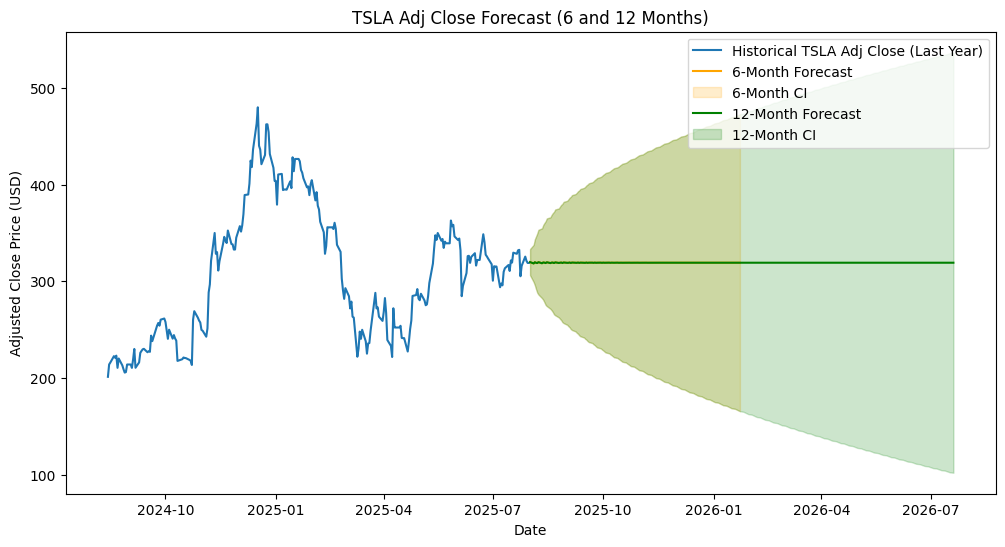

In [7]:
# Plot forecasts
plt.figure(figsize=(12, 6))
plt.plot(tsla_adj_close[-252:], label='Historical TSLA Adj Close (Last Year)')
plt.plot(forecast_6m_df['Forecast'], label='6-Month Forecast', color='orange')
plt.fill_between(forecast_6m_df.index, forecast_6m_df['Lower CI'], forecast_6m_df['Upper CI'], color='orange', alpha=0.2, label='6-Month CI')
plt.plot(forecast_12m_df['Forecast'], label='12-Month Forecast', color='green')
plt.fill_between(forecast_12m_df.index, forecast_12m_df['Lower CI'], forecast_12m_df['Upper CI'], color='green', alpha=0.2, label='12-Month CI')
plt.title('TSLA Adj Close Forecast (6 and 12 Months)')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price (USD)')
plt.legend()
plt.show()
plt.savefig('../plots/forecast_6_12_months.png')
plt.close()


In [6]:
# Save forecasts
forecast_6m_df.to_csv('../data/forecast_6m.csv')
forecast_12m_df.to_csv('../data/forecast_12m.csv')

# Summary statistics and CI width
print("\n6-Month Forecast Summary:")
print(forecast_6m_df.describe())
print("\n12-Month Forecast Summary:")
print(forecast_12m_df.describe())

ci_width_6m = forecast_6m_df['Upper CI'] - forecast_6m_df['Lower CI']
ci_width_12m = forecast_12m_df['Upper CI'] - forecast_12m_df['Lower CI']
print("\nAverage CI Width (6 Months):", ci_width_6m.mean())
print("Average CI Width (12 Months):", ci_width_12m.mean())

# Trend and volatility analysis
trend_6m = 'Upward' if forecast_6m_df['Forecast'].iloc[-1] > forecast_6m_df['Forecast'].iloc[0] else 'Downward' if forecast_6m_df['Forecast'].iloc[-1] < forecast_6m_df['Forecast'].iloc[0] else 'Stable'
trend_12m = 'Upward' if forecast_12m_df['Forecast'].iloc[-1] > forecast_12m_df['Forecast'].iloc[0] else 'Downward' if forecast_12m_df['Forecast'].iloc[-1] < forecast_12m_df['Forecast'].iloc[0] else 'Stable'
print("\nTrend Analysis:")
print(f"6-Month Trend: {trend_6m}")
print(f"12-Month Trend: {trend_12m}")
print(f"CI Width Growth (12M vs 6M): {ci_width_12m.mean() / ci_width_6m.mean():.2f}x")


6-Month Forecast Summary:
         Forecast    Lower CI    Upper CI
count  126.000000  126.000000  126.000000
mean   319.278308  216.418822  422.137795
std      0.165328   35.955099   35.944425
min    318.531611  165.846848  333.402293
25%    319.261280  186.231246  396.865251
50%    319.276615  210.353062  428.179041
75%    319.292554  241.661590  452.325427
max    319.925656  306.449019  472.708279

12-Month Forecast Summary:
         Forecast    Lower CI    Upper CI
count  252.000000  252.000000  252.000000
mean   319.277290  174.207035  464.347544
std      0.116676   50.986449   50.981010
min    318.531611  102.284640  333.402293
25%    319.275755  131.234134  428.399704
50%    319.276277  165.541802  473.010952
75%    319.276952  210.144060  507.318411
max    319.925656  306.449019  536.267910

Average CI Width (6 Months): 205.7189725500303
Average CI Width (12 Months): 290.1405090669867

Trend Analysis:
6-Month Trend: Downward
12-Month Trend: Downward
CI Width Growth (12M vs 6M)